In [68]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from astropy.table import Table
from astropy.table import hstack
import astropy.units as u

from isochrones.mist import MISTEvolutionTrackGrid, MISTIsochroneGrid, MIST_EvolutionTrack

In [22]:
track = MIST_EvolutionTrack()
iso_grid = MISTIsochroneGrid()

from isochrones.mist import MIST_Isochrone
from isochrones import get_ichrone
mist = get_ichrone('mist')


In [4]:
mass, age, feh, distance, AV = 1.0, 9.74, -0.05, 100, 0.02

In [18]:
# Given a mass, age, feh interpolate the isochrone grid to get the photometry of the star
#eep = mist.get_eep(mass, age,feh, accurate=True)
isochrone = iso_grid.interp([mass, age*1e9, feh])

In [29]:
mist = MIST_Isochrone()

pars = [353, 9.78, -1.24]  # eep, log(age), feh
mist.interp_value(pars, ['mass', 'radius', 'Teff', 'logg'])

array([8.33122954e-307, 8.33122954e-307, 8.33122954e-307, 8.33122954e-307])

In [31]:
mist.interp_mag(pars, ['K', 'BP', 'RP']) 

(-3.099250687999979,
 -3.104169167999979,
 -3.10175266399998,
 array([nan, nan, nan]))

In [162]:
from isochrones import get_ichrone
import numpy as np
from tqdm import tqdm

def get_star_photometry_old(feh: np.array, initial_mass: np.array, age_ejection: np.array, flight_time: np.array):
    """
    Retrieve Gaia photometry for a star given its initial mass, metallicity (feh),
    and age using the MIST isochrone model.

    Parameters:
    - feh: float, the metallicity [Fe/H] of the star.
    - initial_mass: float, the initial mass of the star in solar masses.
    - age: float, the current age of the star in Gyr.

    Returns:
    - dict with Gaia magnitudes 'G', 'BP', and 'RP' if available.
    """
    # Load the MIST isochrone model
    mist = get_ichrone('mist')

    age = age_ejection + flight_time


    # Generate the star's model with `generate`, which returns a dictionary of properties
    # Documentation Reference: https://isochrones.readthedocs.io/en/latest/usage.html#model-parameters
    try:
        star_model = mist.generate(mass=initial_mass, age=age, feh=feh, accurate=True)
    except (ValueError, RuntimeError) as e:
        print(f"Error during model generation: {e}")
        return {'G': np.nan, 'BP': np.nan, 'RP': np.nan}


            # Extract Gaia photometry (G, BP, RP) from the star model
    result = {
        'G': star_model.get('G_mag', np.nan),
        'BP': star_model.get('BP_mag', np.nan),
        'RP': star_model.get('RP_mag', np.nan),
        'Teff': star_model.get('Teff', np.nan),
        'logg': star_model.get('logg', np.nan),
        'radius': star_model.get('radius', np.nan),
        'logL': star_model.get('logL', np.nan),
        'feh': star_model.get('feh', np.nan),
        'eep': star_model.get('eep', np.nan)
    }

    return Table(result)

# Example usage
if __name__ == "__main__":
    feh = [0.25]        # Example metallicity [Fe/H]
    initial_mass = [1.0] # Example mass in solar masses
    age = [5.0]          # Example age in Gyr
    flight_time = [0.5]   

    photometry = get_star_photometry_old(feh, initial_mass, age, flight_time)
    print(f"Photometry for the star at age {age} Gyr:")
    print(f"G: {photometry['G']}, BP: {photometry['BP']}, RP: {photometry['RP']}")


Error during model generation: EEP minimization not successful: (np.float64(1.0), np.float64(0.5), np.float64(0.25))
Photometry for the star at age [5.0] Gyr:
G: nan, BP: nan, RP: nan


In [199]:
from isochrones import get_ichrone
import numpy as np
from astropy.table import Table

def get_star_photometry_v2(feh_array, initial_mass_array, age_ejection_array, flight_time_array):
    """
    Retrieve Gaia photometry for a set of stars given their initial masses, metallicities (feh),
    and ages using the MIST isochrone model.

    Parameters:
    - feh_array: array-like, metallicities [Fe/H] of the stars.
    - initial_mass_array: array-like, initial masses of the stars in solar masses.
    - age_ejection_array: array-like, ejection ages of the stars in Gyr.
    - flight_time_array: array-like, flight times of the stars in Gyr.

    Returns:
    - pandas DataFrame with Gaia magnitudes 'G', 'BP', 'RP', and other stellar properties.
    """
    # Load the MIST isochrone model
    mist = get_ichrone('mist')

    results = []

    # Iterate over each star's parameters
    for feh, initial_mass, age_ejection, flight_time in zip(
            feh_array, initial_mass_array, age_ejection_array, flight_time_array):
        
        age = np.log10((age_ejection + flight_time)) + 9 # Convert age to log10(age) in yr

        try:
            # Generate the star's model
            star_model = mist.generate(mass=initial_mass, age=age, feh=feh, accurate=True)
            
            # Extract scalar values from the DataFrame
            G_mag = star_model['G_mag'].values[0]
            BP_mag = star_model['BP_mag'].values[0]
            RP_mag = star_model['RP_mag'].values[0]
            Teff = star_model['Teff'].values[0]
            logg = star_model['logg'].values[0]
            radius = star_model['radius'].values[0]
            logL = star_model['logL'].values[0]
            feh_value = star_model['feh'].values[0]
            eep = star_model['eep'].values[0]
            
            result = {
                'G': G_mag,
                'BP': BP_mag,
                'RP': RP_mag,
                'Teff': Teff,
                'logg': logg,
                'radius': radius,
                'logL': logL,
                'feh': feh_value,
                'eep': eep
            }
        except (ValueError, RuntimeError, IndexError) as e:
            print(f"Error during model generation for star with mass {initial_mass}, "
                  f"age {age}, feh {feh}: {e}")
            # Assign NaN values if generation fails
            result = {
                'G': np.nan,
                'BP': np.nan,
                'RP': np.nan,
                'Teff': np.nan,
                'logg': np.nan,
                'radius': np.nan,
                'logL': np.nan,
                'feh': np.nan,
                'eep': np.nan
            }
        
        results.append(result)

    return Table(results)

In [200]:
# test on catalog
pmage_catalog = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/SFH_sampling_catalogs/initial/sample_NSC.fits')
print(pmage_catalog.columns)

<TableColumns names=('mass','age','flight_time')>


In [201]:
pmage_catalog

mass,age,flight_time
solMass,Gyr,Gyr
float64,float64,float64
0.1400624261755766,6.6028308686826644,5.519621440806965
0.11678222893069126,5.693950155191098,7.1227137725939
0.11106970590664389,10.752883708617833,1.3771757187316378
0.1649303813509785,2.3719340149248906,8.684637395220062
0.1716065035291909,9.211427734831503,3.314081265370164
0.18640206764672013,1.5219521810707424,10.563400843108514
0.1981871353911785,10.745193679831845,2.21580935461009
0.11490578712856621,0.5606409554880913,5.298546232115724


In [202]:
pmage_catalog_with_photometry = hstack([pmage_catalog, get_star_photometry_v2([0]*len(pmage_catalog), pmage_catalog['mass'], pmage_catalog['age'], pmage_catalog['flight_time'])])

In [203]:
pmage_catalog_with_photometry.to_pandas().dropna()

,mass,age,flight_time,G,BP,RP,Teff,logg,radius,logL,feh,eep
0,0.140062,6.602831,5.519621,12.582886,14.381609,11.377411,3083.422822,5.138407,0.167553,-2.649277,0.045978,252.724514
1,0.116782,5.693950,7.122714,13.261056,15.339588,12.005831,2969.885665,5.194589,0.143590,-2.853005,0.045322,248.771782
2,0.111070,10.752884,1.377176,13.435937,15.597524,12.169998,2941.834384,5.208466,0.137701,-2.903204,0.045011,246.397419
3,0.164930,2.371934,8.684637,12.068596,13.688980,10.899304,3161.855658,5.093663,0.191107,-2.487890,0.046300,254.284515
4,0.171607,9.211428,3.314081,11.961089,13.549575,10.798321,3175.877720,5.082998,0.197398,-2.452887,0.046893,257.446289
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.112169,4.557007,6.432870,13.403803,15.550391,12.139799,2946.896097,5.205988,0.138802,-2.893936,0.044813,244.570713
9996,0.100754,7.120249,4.565248,13.749838,16.060216,12.464789,2891.465872,5.233349,0.127099,-2.993518,0.044659,243.330860
9997,0.139090,6.223737,6.440474,12.610003,14.419132,11.402428,3078.853832,5.140622,0.166577,-2.657556,0.046088,253.411217
9998,0.108910,5.474868,5.867631,13.502517,15.695813,12.232498,2931.109428,5.213778,0.135465,-2.922320,0.044799,244.498386


In [194]:
pmage_catalog_with_photometry.write('/Users/mncavieres/Documents/2024-2/HVS/Data/SFH_sampling_catalogs/MIST_photometry/sample_NSC_with_photometry.fits', overwrite=True)

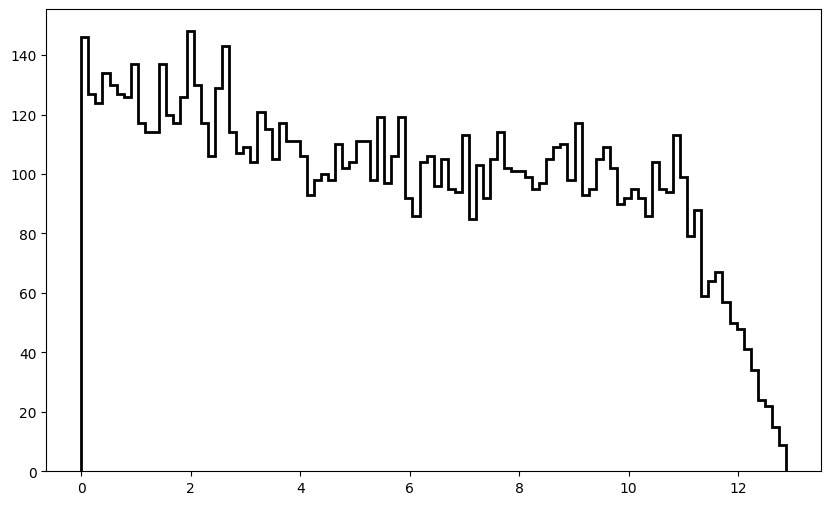

In [204]:
plt.figure(figsize=(10, 6))
plt.hist(pmage_catalog_with_photometry['age'], bins=100, histtype='step', lw=2, color='k')
plt.show()

## Test with simple populations

In [235]:
ages = np.linspace(0.1, 13, 1000)
mass = [1.0] * len(ages)
feh = [0.0] * len(ages)

In [236]:
get_star_photometry_v2

<function __main__.get_star_photometry_v2(feh_array, initial_mass_array, age_ejection_array, flight_time_array)>

In [237]:
testing_evol_track = get_star_photometry_v2(feh, mass, ages, [0]*len(ages))

Error during model generation for star with mass 1.0, age 10.079854554123724, feh 0.0: EEP minimization not successful: (1.0, 10.079854554123724, 0.0)
Error during model generation for star with mass 1.0, age 10.080320913570734, feh 0.0: EEP minimization not successful: (1.0, 10.080320913570734, 0.0)
Error during model generation for star with mass 1.0, age 10.080786772763043, feh 0.0: EEP minimization not successful: (1.0, 10.080786772763043, 0.0)
Error during model generation for star with mass 1.0, age 10.081252132772729, feh 0.0: EEP minimization not successful: (1.0, 10.081252132772729, 0.0)
Error during model generation for star with mass 1.0, age 10.081716994668424, feh 0.0: EEP minimization not successful: (1.0, 10.081716994668424, 0.0)
Error during model generation for star with mass 1.0, age 10.082181359515337, feh 0.0: EEP minimization not successful: (1.0, 10.082181359515337, 0.0)
Error during model generation for star with mass 1.0, age 10.082645228375261, feh 0.0: EEP min

In [238]:
testing_evol_track = testing_evol_track.to_pandas().dropna()

(8.0, -5.0)

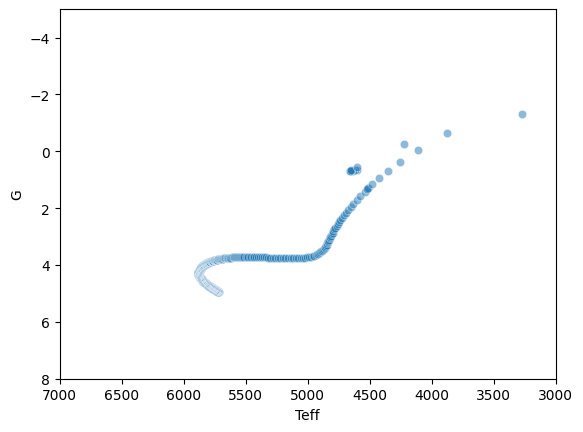

In [239]:
sns.scatterplot(data=testing_evol_track, x='Teff', y='G', alpha=0.5)
plt.xlim(7000, 3000)
plt.ylim(8, -5)